In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
from datasets import list_datasets, load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from pprint import pprint


/home/fpaludi/projects/Git/ExploreTransformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/tmp/ipykernel_1614041/2416910594.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 46048 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
emotions = load_dataset("emotion")
train_ds = emotions["train"]

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/fpaludi/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 720.34it/s]


In [4]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


In [7]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Explore data

Text(0.5, 1.0, 'Frequency of Classes')

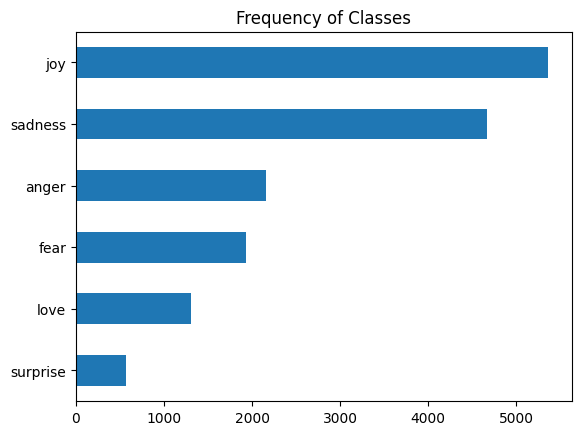

In [8]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")

<Axes: xlabel='label_name', ylabel='Words Per Tweet'>

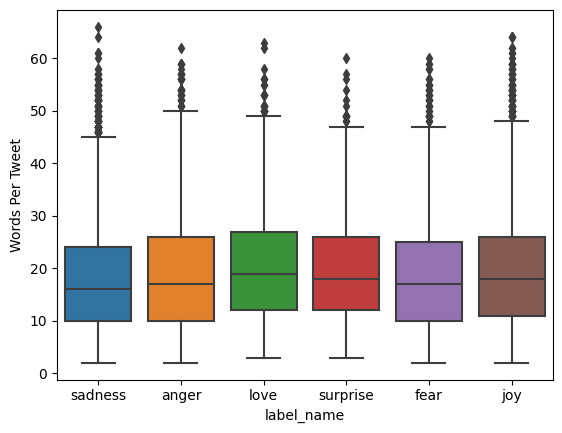

In [9]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
sns.boxplot(y="Words Per Tweet", x="label_name", data=df)

# Tokernizer

## Character tokenizer

The simplest tokenization scheme is to feed each character individually to the model

This requires significant
compute, memory, and data. For this reason, character tokenization is rarely used in
practice.

## Words tokenizer

Given that words can include declinations, conjugations, or misspellings, the
size of the vocabulary can easily grow into the millions!


 To illustrate this, suppose we have 1 million unique
words and want to compress the 1-million-dimensional input vectors to 1-thousand-
dimensional vectors in the first layer of our neural network. This is a standard step in
most NLP architectures, and the resulting weight matrix of this first layer would con‐
tain 1 million × 1 thousand = 1 billion weights. This is already comparable to the
largest GPT-2 model,4 which has around 1.5 billion parameters in total!


Wouldn’t it be nice if there was a compromise between character and word tokeniza‐
tion that preserved all the input information and some of the input structure? There
is: subword tokenization.


## Sub-word tokenizer

The main distinguishing feature of
subword tokenization (as well as word tokenization) is that it is learned from the pre‐
training corpus using a mix of statistical rules and algorithms.


Let’s start with WordPiece, which is used by the BERT and DistilBERT 

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
pprint(encoded_text)


{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
               19204,
               6026,
               3793,
               2003,
               1037,
               4563,
               4708,
               1997,
               17953,
               2361,
               1012,
               102]}


In [12]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)


['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


1. [CLS] and [SEP] tokens have been added to the start and end of the sequence.
1. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that “tokenizing” and “NLP” have been split into two tokens, which makes sense since they are not common words. 
1. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; 

In [13]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


Tokneizer have interesting attributes

In [14]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


# Train Models

## Tokenize dataset


padding=True will pad the examples with zeros to the size of the longest one in a batch

truncation=True will truncate the examples to the model’s maximum context size

In [15]:
def tokenize(batch):
    
    # tokenizer(batch["text"].tolist(), padding=True, truncation=True)
    return tokenizer(batch["text"], padding=True, truncation=True)

    #batch["input_ids"] = result["input_ids"]
    #batch["attention_mask"] = result["attention_mask"]
    #return batch


In [16]:
emotions.set_format("torch")

In [17]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/fpaludi/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-8fd78abdb68c8535.arrow
Loading cached processed dataset at /home/fpaludi/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-04ca9eea911530a2.arrow
Loading cached processed dataset at /home/fpaludi/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-31c0a9f58f45f68e.arrow


In [19]:
emotions_encoded["train"].column_names


['text', 'label', 'input_ids', 'attention_mask']

## Transformer as feature extractor

 The advantage of this approach is that we can quickly train a small or shal‐
low model. Such a model could be a neural classification layer or a method that does
not rely on gradients, such as a random forest. This method is especially convenient if
GPUs are unavailable, since the hidden states only need to be precomputed once.


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
model_ckpt = "distilbert-base-uncased"
# device = "cpu"
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {
        k: v.to(device) for k, v in batch.items()
        if k in tokenizer.model_input_names
    }
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [35]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=100)

In [ ]:
emotions_hidden["train"].column_names

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

In [33]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)


0.6325

In [27]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues")


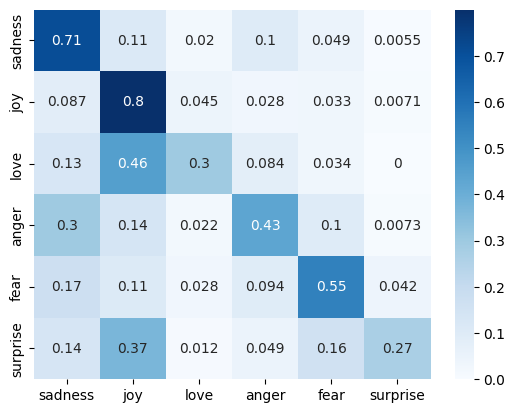

In [44]:
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Finetune Transformers

This requires the classification head to be differentiable,
which is why this method usually uses a neural network for classification.


In [20]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments


In [21]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) #.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [23]:
batch_size = 64

logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)


/home/fpaludi/projects/Git/ExploreTransformers/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

/home/fpaludi/projects/Git/ExploreTransformers/.venv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.815800,0.301031,0.909000,0.907293
2,0.241500,0.210737,0.927000,0.926753


TrainOutput(global_step=500, training_loss=0.5286452407836915, metrics={'train_runtime': 4240.8873, 'train_samples_per_second': 7.546, 'train_steps_per_second': 0.118, 'total_flos': 720342861696000.0, 'train_loss': 0.5286452407836915, 'epoch': 2.0})

In [25]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [41]:
y_valid = emotions_encoded["validation"]["label"]
labels = emotions["train"].features["label"].names

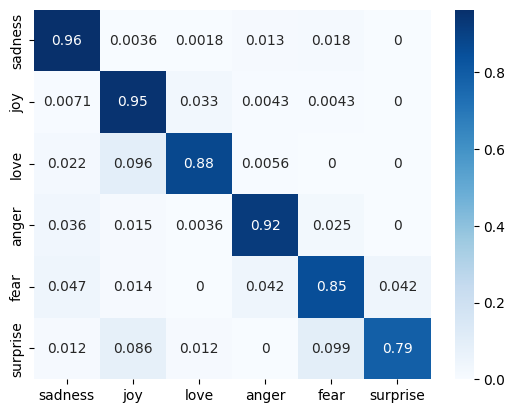

In [42]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Error Analysis

In [43]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {
        k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(
        output.logits, 
        batch["label"].to(device),
        reduction="none"
    )
    # Place outputs on CPU for compatibility with other dataset columns
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }


In [44]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)


In [45]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)


In [46]:
df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.491143
1111,im lazy my characters fall into categories of ...,joy,fear,5.268126
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.194786
1509,i guess this is a memoir so it feels like that...,joy,fear,4.926887
1950,i as representative of everything thats wrong ...,surprise,sadness,4.808914
1801,i feel that he was being overshadowed by the s...,love,sadness,4.795405
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.784897
1683,i had applied for a job and they had assured m...,anger,joy,4.422356
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.398281
882,i feel badly about reneging on my commitment t...,love,sadness,4.306813
